In [1]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# **Rocket State & Trajectory**
Definition: 
In formulation of rocket landing problem  the rocket state $x(t)$ is the state vector, $x(t) \in R^5 $, and action $a(t)$ is the contorl inputs, $a(t)\in R^2$

$$s(t) =
 \begin{bmatrix}
   x(t)\\
   y(t)\\
   v_x(t)\\
   v_y(t)\\
   \theta(t)
 \end{bmatrix},
 a(t) =
 \begin{bmatrix}
   thrust\\
   \dot{\theta}\\
 \end{bmatrix}
 $$

where $v_x(t),v_y(t)$ are the velocity in $x(t)$ and $y(t)$ direction and $\theta$ is the heading of the rocket at $t$ specifies time.


Definition: a trajectory is a collocation of rocket states
$$ trajectory = {s_0,s_1,s_2,…,s_n} $$

$s(t)$ is the rocket state at step $t$.

In [2]:
# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.
BOOST_ACCEL = 0.18  # thrust constant
Cd = 1
rho = 0.07967 # density 
A =1 # area of Crossection  of rocket 

# Dynamics of Model
Dynamics  of Model defines how the rocket move. It maps a previous state to the current state.

Definition: The state dynamics model is a function, dynamics $\in R^5 → R^5$.
In vector form,

$$s(t+1) =
 \begin{bmatrix}
   x(t+1)\\
   y(t+1)\\
   v_x(t+1)\\
   v_y(t+1)\\
   \theta(t+1)
 \end{bmatrix}
 =
 \begin{bmatrix}
   x(t) + v_x(t)\Delta t\\
   y(t) + v_y(t)\Delta t\\
   v_x(t) + cos(\theta)*thrust\\
   v_y(t) + sin(\theta)*thrust - gravity_y - drag_y\\
   \theta(t) + \dot{\theta}\Delta t
 \end{bmatrix}
 $$


where  
$ darg_y ={\dfrac{drag force}{mass}}\Delta t$,

$drag force = -{\dfrac{1}{2}}\rho *v_y^2*A*C_d $

we assumed that mass of rocket = 1

$darg_y = -{\dfrac{1}{2}}\rho *v_y^2*A*C_d \Delta t $



The position $x$ and $y$ are updated by $\Delta t$ times velocity.

The velocity $v_x$ is updated by $\Delta t$ times thrust in the direction of the rocket and velocity $v_y$ is updated by $\Delta t$ times thrust, gravity  and drag in $-y$ direction . 

The heading $\theta$ is updated by $\Delta t$ times the control variable $\dot{\theta}$˙ (which could be a oversimplification of rocket model).

The class Dynamics implements $s(t+1) = Dynamics(s(t))$

In [15]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
      
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... @cc antantantant (Prof Max Yi Ren)

        delta_state_gravity = torch.tensor([0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Thrust for N initial state
        # N = len(state)
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])
    
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1)) 

        #for drag
        Vy = torch.matmul(state,torch.tensor([0., 0., 0., 1., 0.]))

        drag_y = -0.5*rho*Vy*Vy*A*Cd

        state = state + delta_state  + delta_state_gravity + delta_state_theta - drag_y 

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        

        state = torch.matmul(step_mat, state.T)
        return (state.T)


# Controller
The class Controller defines rocket action in closed-loop: i.e what are the thrust value and what should be the angular velocity.

let the closed-loop controller be $$ a(t)=f_\Theta(s(t))$$

where $f_\Theta(\cdot)$ is a neural network with parameters $\Theta$, which are to be determined through optimization.

The retun of nural netwok is the action space 
$$
 a(t) =
 \begin{bmatrix}
   thrust\\
   \dot{\theta}\\
 \end{bmatrix}
 $$

$thrust \in [0,1]$  and $\dot{\theta} \in [-1,1] $ 

In [16]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action

The landing cost, $$ cost({s_0,s_1,…,s_n}) = \sum || s(t+1)-Dynamics(s(t)) || ^2$$




$||s(t+1)-Dynamics(s(t)) || ^2$ : says we want two consecutive states follow the Dynamic model.


Now the rocket landing problem is formulated as a least squares problem. we can solve this least squares problem by using gradient decent.

In [17]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = [[1.,1.,0.,0.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)


The optimization problem is now formulated as: \



$$ \min_{\theta} || cost({s_0,s_1,…,s_n}) ||^2\\
s.t.\ \  x(t+1) = x(t) + v_x(t)\Delta t\\
   y(t+1) = y(t) + v_y(t)\Delta t\\
   v_x(t+1)=v_x(t) + cos(\theta)*thrust\\
  v_y(t+1)= v_y(t) + sin(\theta)*thrust - gravity_y - drag_y\\
  a(t) = f_\Theta(s(t)) ,∀t =1, . . . T-1
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$ where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\Theta$

In [18]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'k', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')

        plt.show()

[1] loss: 10.380


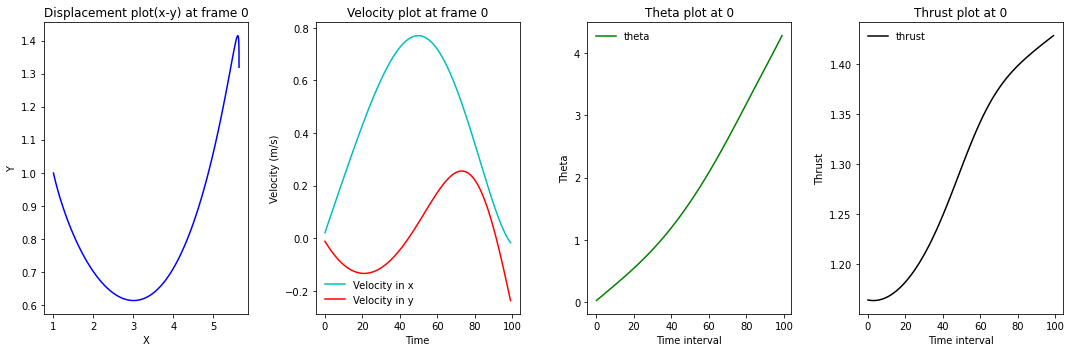

[2] loss: 7.530


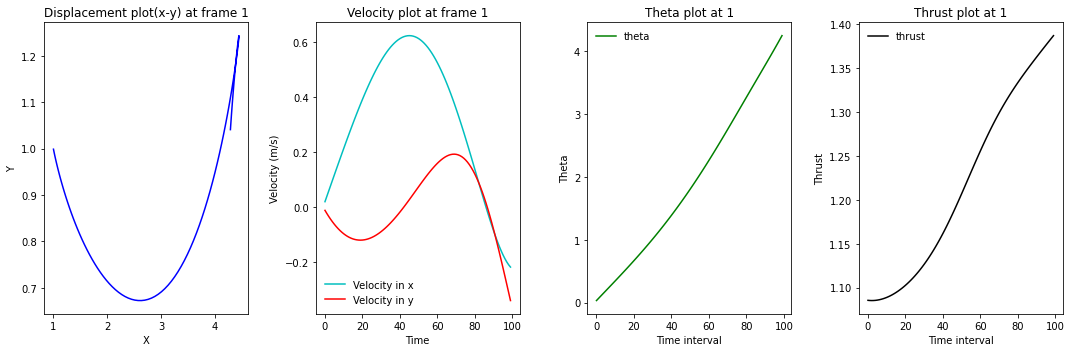

[3] loss: 5.592


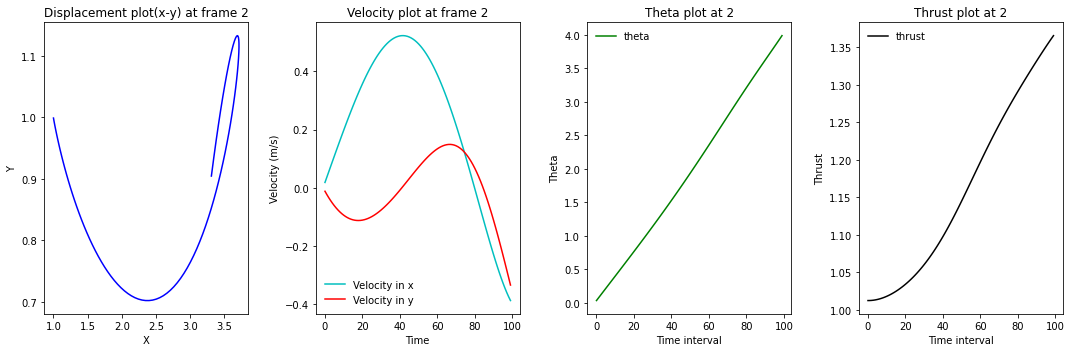

[4] loss: 3.717


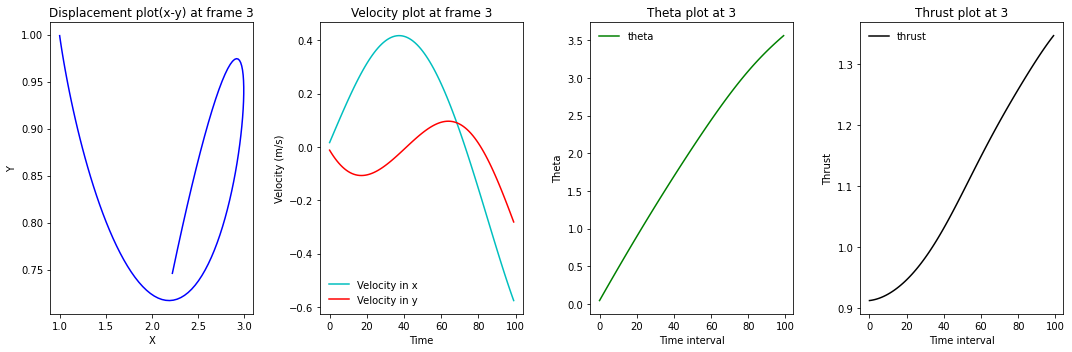

[5] loss: 2.406


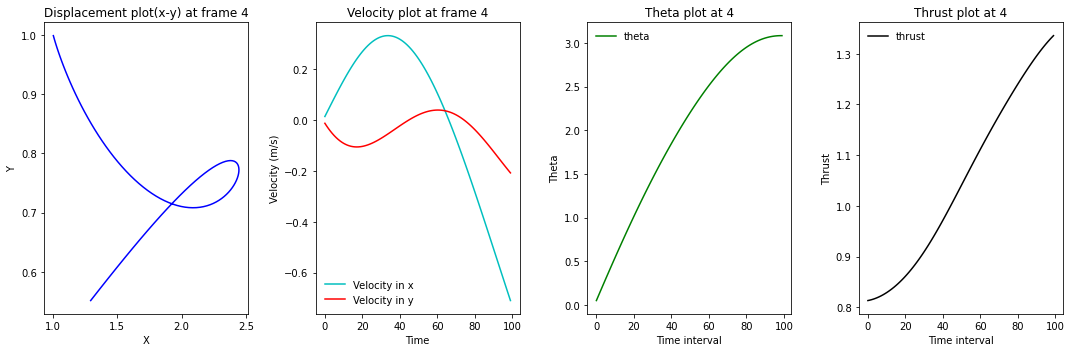

[6] loss: 1.438


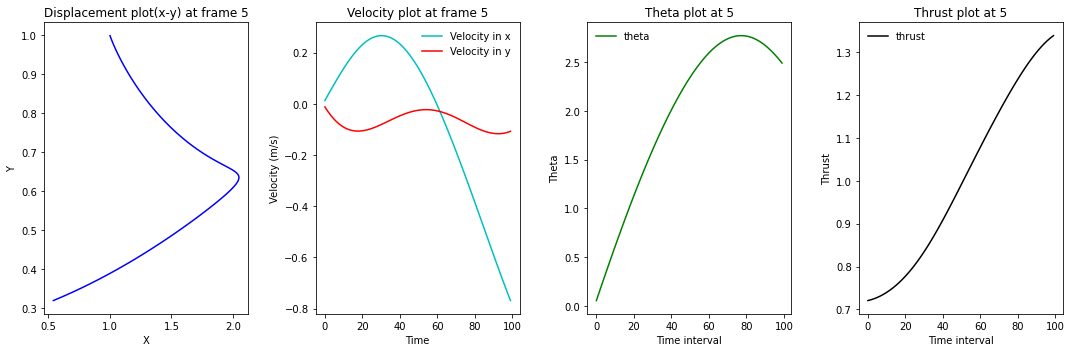

[7] loss: 0.809


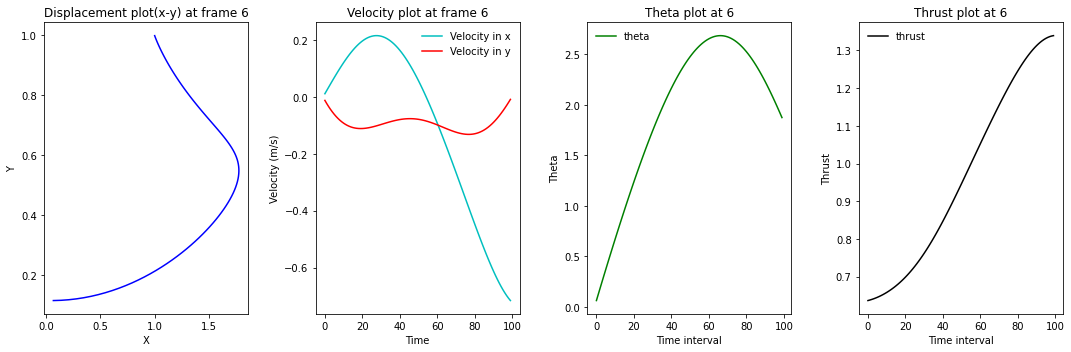

[8] loss: 0.425


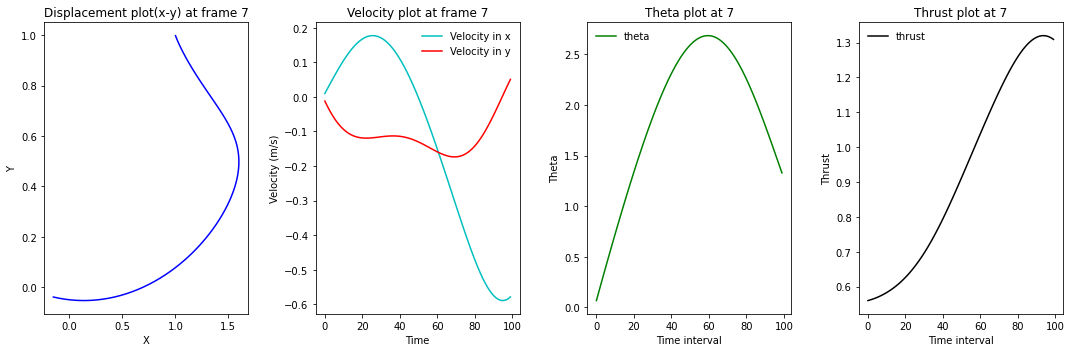

[9] loss: 0.209


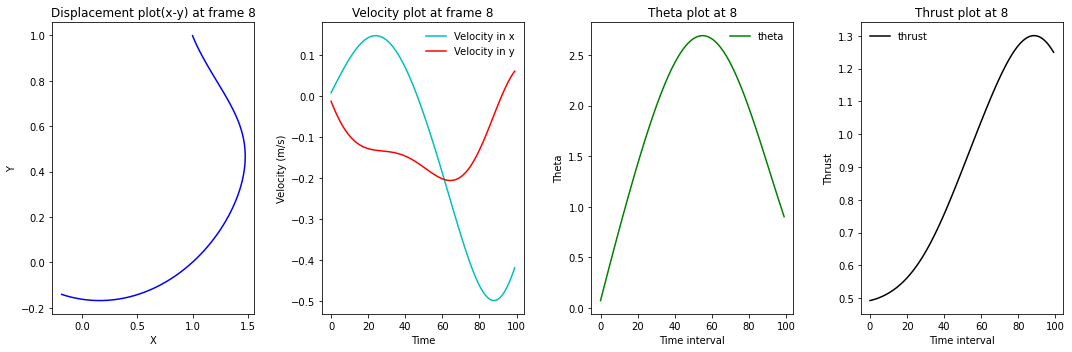

[10] loss: 0.117


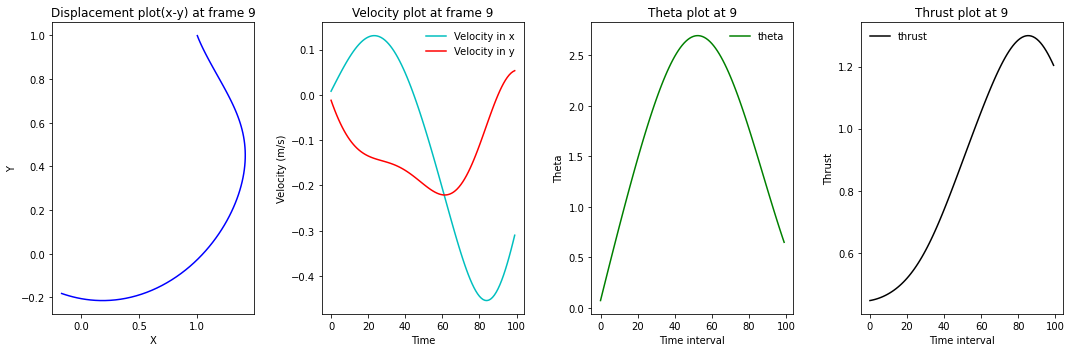

[11] loss: 0.068


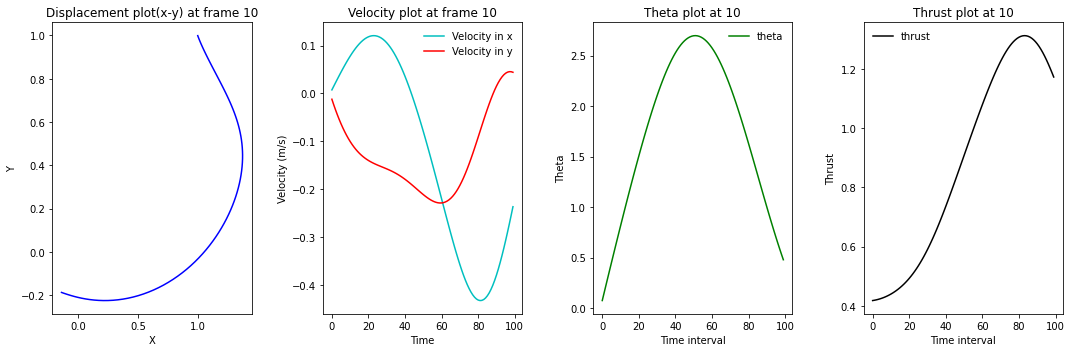

[12] loss: 0.041


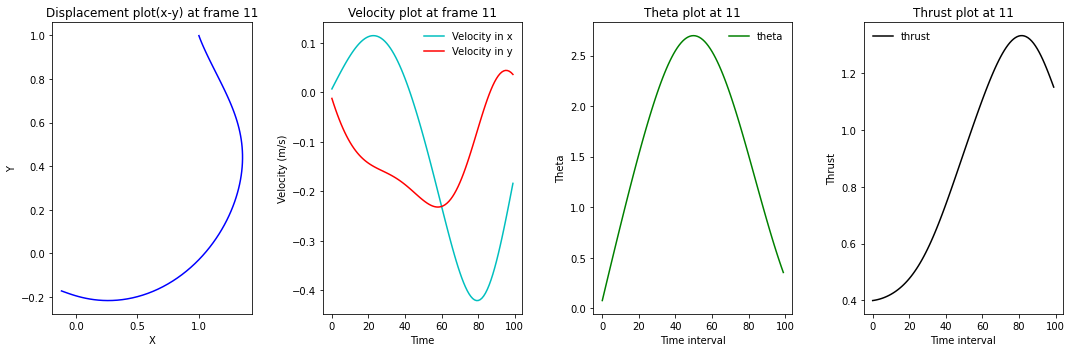

[13] loss: 0.025


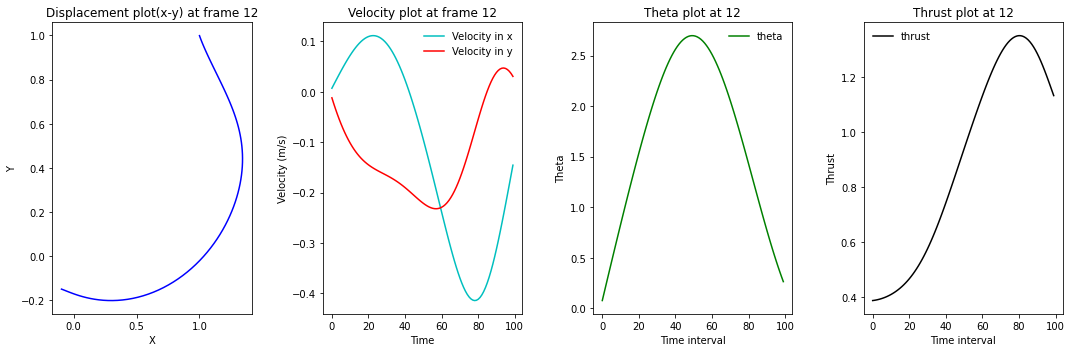

[14] loss: 0.015


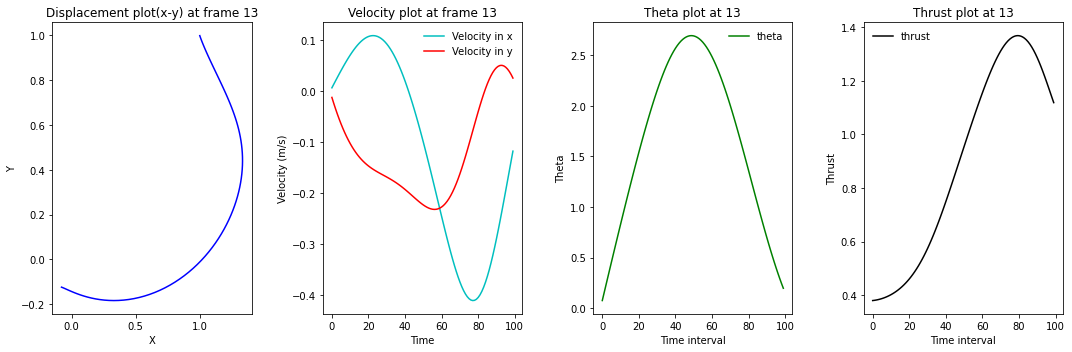

[15] loss: 0.009


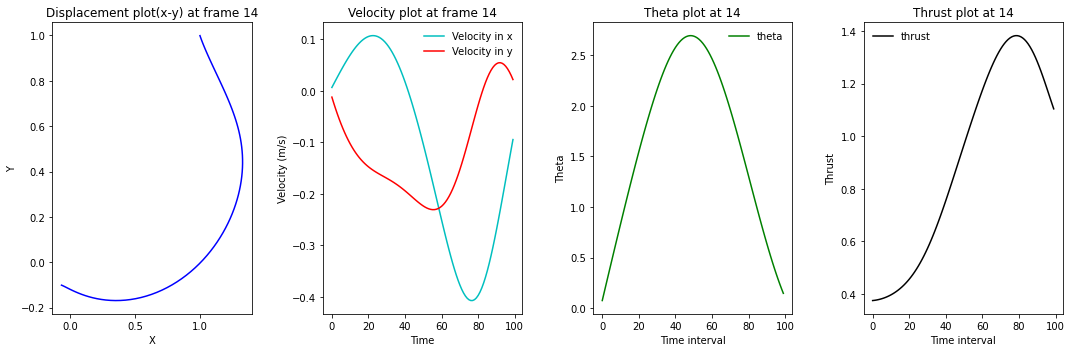

[16] loss: 0.005


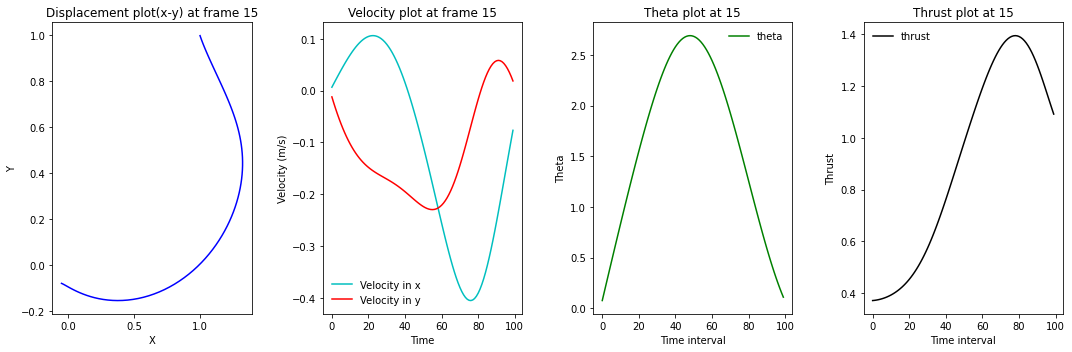

[17] loss: 0.003


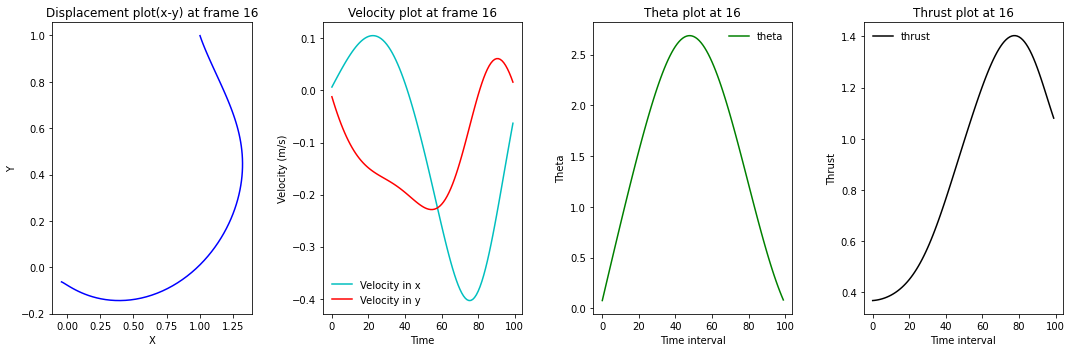

[18] loss: 0.002


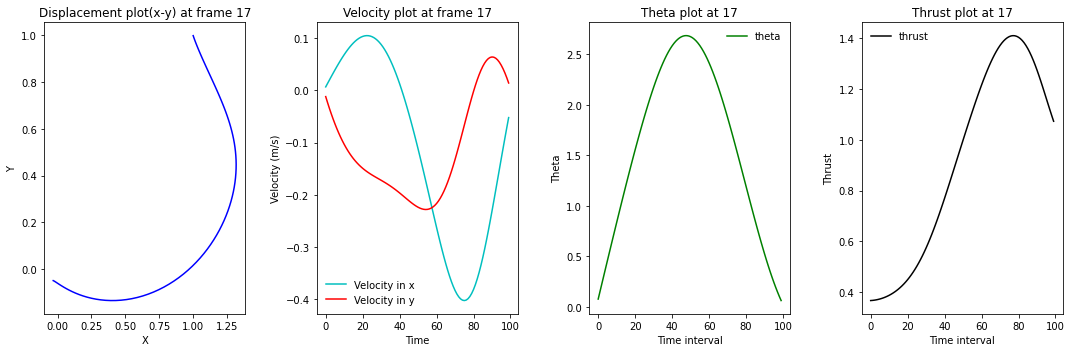

[19] loss: 0.001


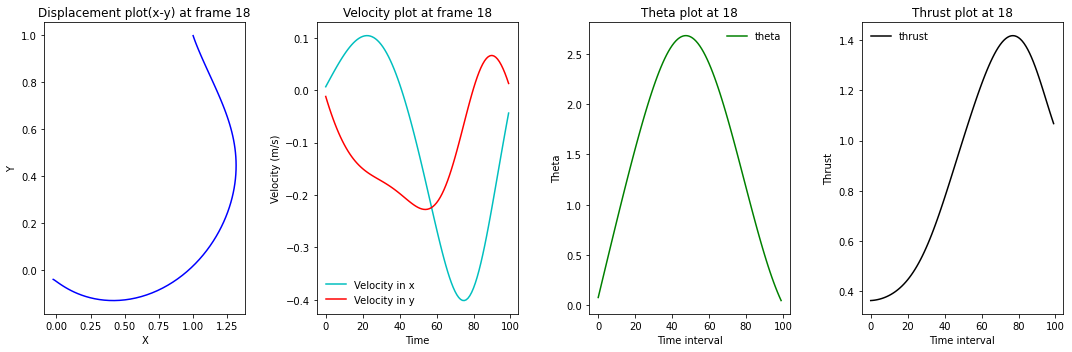

[20] loss: 0.001


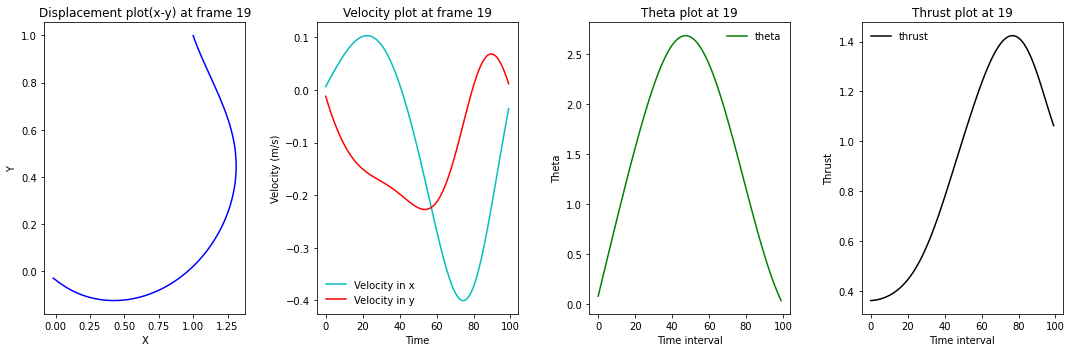

[21] loss: 0.000


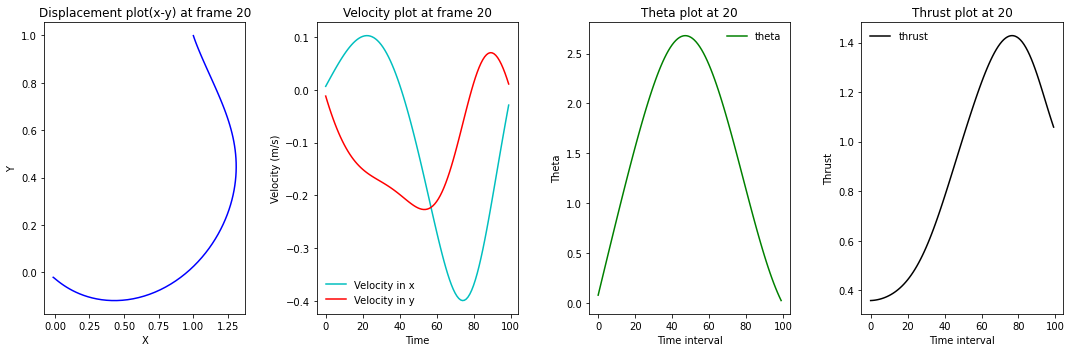

[22] loss: 0.000


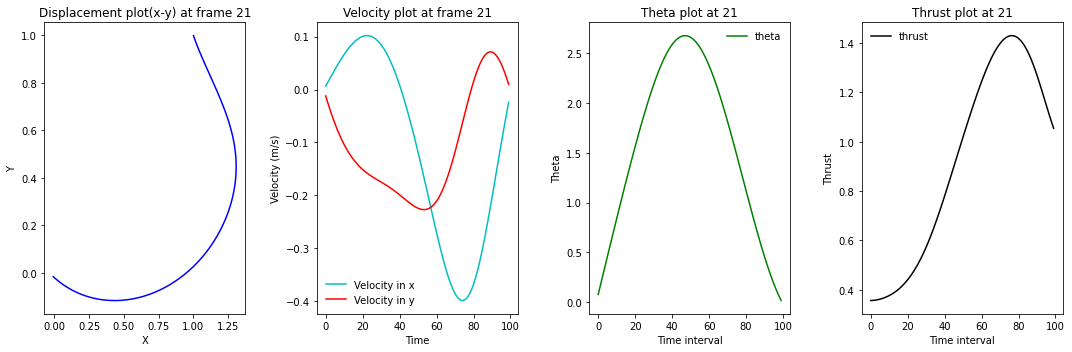

[23] loss: 0.000


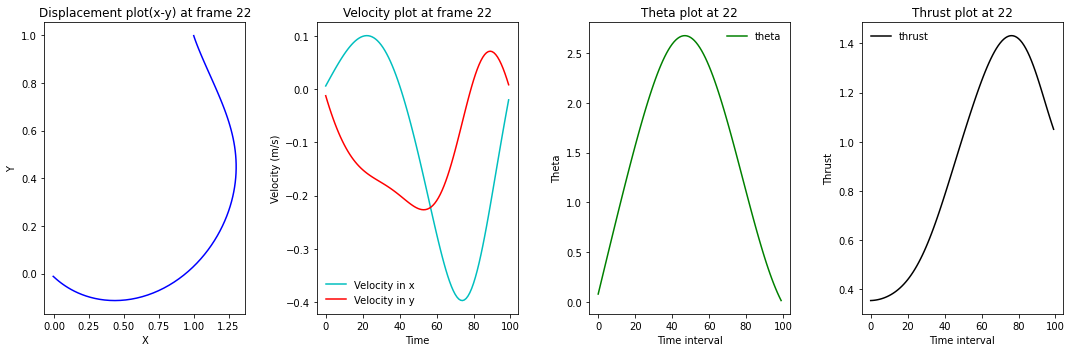

[24] loss: 0.000


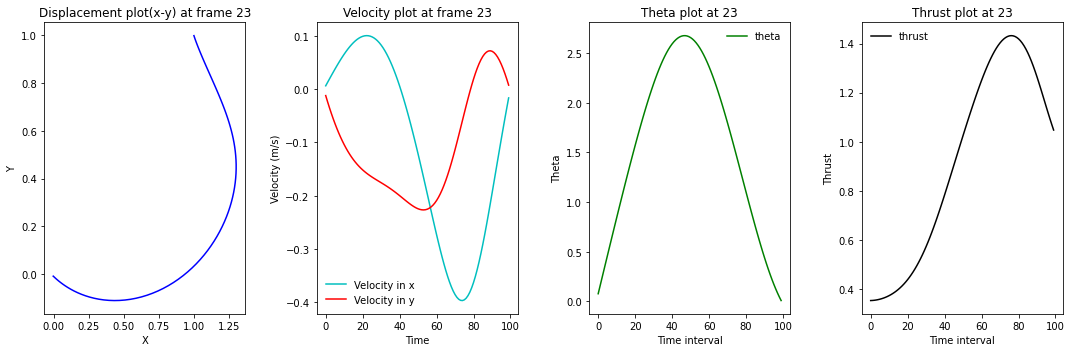

[25] loss: 0.000


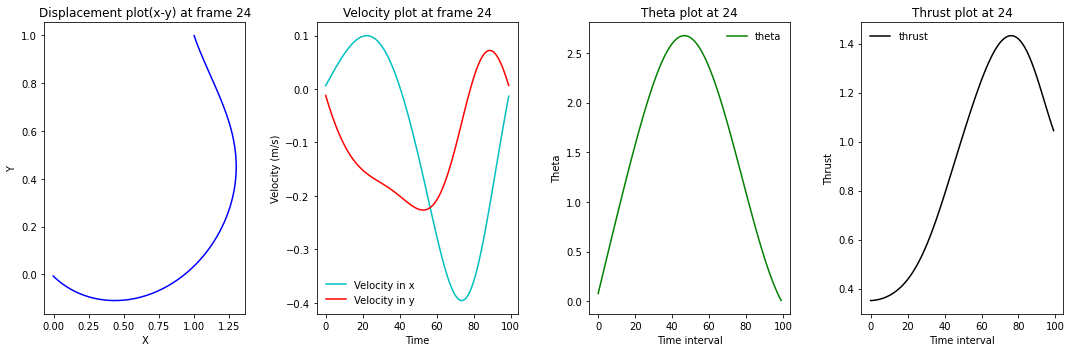

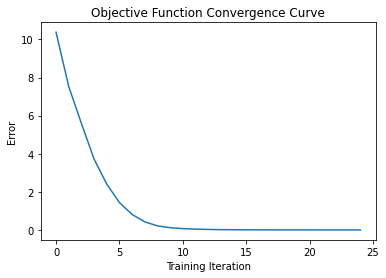

In [19]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(25)  # training with number of epochs